# VAEP 성능 분석 노트북

이 노트북은 VAEP 파이프라인의 결과를 분석하고 성능 지표를 계산합니다.

## 분석 내용
1. 데이터 로드 및 기본 통계
2. 선수별 VAEP 분포 분석
3. 포지션별 VAEP 비교
4. 상위/하위 선수 식별
5. 경기당 VAEP 변동성 분석
6. 경기별 VAEP 추이
7. 요약 통계
8. **골키퍼 전용 분석** ⚽ (NEW)
9. **전체 선수 시각화** 📊 (NEW)
   - 모든 선수 산점도 (골키퍼 vs 필드 플레이어)
   - 포지션별 VAEP 분포
   - Top 50 전체 랭킹

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 1. 데이터 로드

In [34]:
# 데이터 경로 설정
from pathlib import Path

# 모델 버전 지정 (latest 또는 특정 버전)
MODEL_VERSION = "20251127_020923"  # 또는 "latest"로 변경하여 최신 버전 사용
DATA_DIR = Path(f'../models/{MODEL_VERSION}/results')

# Player-match VAEP 로드
player_match_df = pd.read_csv(DATA_DIR / 'player_match_vaep_england.csv')
print(f"Player-match data shape: {player_match_df.shape}")
print(f"Columns: {player_match_df.columns.tolist()}")
print("\nFirst few rows:")
player_match_df.head()


Player-match data shape: (11178, 8)
Columns: ['playerId', 'matchId', 'teamId', 'vaep', 'num_events', 'minutes_played', 'vaep_per90', 'role']

First few rows:


,playerId,matchId,teamId,vaep,num_events,minutes_played,vaep_per90,role
0,0,2499719,1609,-0.987711,62,90.0,-0.987711,NaN
1,0,2499719,1631,0.180549,102,90.0,0.180549,NaN
2,0,2499720,1625,-0.005703,22,90.0,-0.005703,NaN
3,0,2499720,1651,0.039057,92,90.0,0.039057,NaN
4,0,2499721,1610,0.006778,29,90.0,0.006778,NaN


In [35]:
# Player-season VAEP 로드
player_season_df = pd.read_csv(DATA_DIR / 'player_season_vaep_england.csv')
print(f"Player-season data shape: {player_season_df.shape}")
print(f"Columns: {player_season_df.columns.tolist()}")
print("\nFirst few rows:")
player_season_df.head()

Player-season data shape: (515, 8)
Columns: ['playerId', 'matches_played', 'season_vaep_total', 'season_vaep_per90_avg', 'minutes_played', 'num_events', 'role', 'season_vaep_per_match']

First few rows:


,playerId,matches_played,season_vaep_total,season_vaep_per90_avg,minutes_played,num_events,role,season_vaep_per_match
0,25604,1,1.027846,1.027846,90.0,56,MD,1.027846
1,8717,37,19.676787,0.530942,3195.0,1857,FW,0.531805
2,8325,25,13.033241,0.520208,2160.0,1296,FW,0.521330
3,8374,4,0.955189,0.477005,270.0,145,MD,0.238797
4,120353,36,14.125019,0.446843,3105.0,2132,FW,0.392362


In [ ]:
# 선수 정보 로드 및 매핑 딕셔너리 생성
import json
import codecs

PLAYERS_JSON_PATH = Path('../data/wyscout/players.json')

# players.json 로드
with open(PLAYERS_JSON_PATH, 'r', encoding='utf-8') as f:
    players_data = json.load(f)

# 유니코드 이스케이프 시퀀스를 디코딩하는 헬퍼 함수
def decode_unicode_escapes(text):
    r"""유니코드 이스케이프 시퀀스(\uXXXX)를 실제 문자로 디코딩"""
    if not isinstance(text, str):
        return text
    try:
        # 문자열에 유니코드 이스케이프 시퀀스가 있는지 확인
        if '\\u' in text:
            # latin-1로 인코딩 후 unicode_escape로 디코딩
            return text.encode('latin-1').decode('unicode_escape')
        return text
    except (UnicodeDecodeError, UnicodeError, UnicodeEncodeError):
        # 디코딩 실패 시 원본 반환
        return text

# 선수 ID -> 이름 매핑 딕셔너리 생성
player_id_to_name = {}
for player in players_data:
    wy_id = player.get('wyId')
    if wy_id is not None:
        # shortName 우선, 없으면 firstName + lastName 조합
        name = player.get('shortName', '')
        if not name:
            first_name = player.get('firstName', '')
            last_name = player.get('lastName', '')
            name = f"{first_name} {last_name}".strip()
        if not name:
            name = f"Player {wy_id}"  # 이름이 없으면 기본값
        
        # 유니코드 이스케이프 시퀀스 디코딩
        name = decode_unicode_escapes(name)
        player_id_to_name[int(wy_id)] = name

print(f"선수 정보 로드 완료: {len(player_id_to_name):,}명")
print(f"VAEP 데이터의 고유 선수 수: {player_season_df['playerId'].nunique():,}")

# 선수 이름을 가져오는 헬퍼 함수
def get_player_name(player_id):
    """선수 ID를 받아서 이름을 반환. 없으면 ID만 반환"""
    return player_id_to_name.get(int(player_id), f"Player {player_id}")

# 테스트
sample_ids = player_season_df['playerId'].head(5).values
print("\n샘플 선수 이름 매핑:")
for pid in sample_ids:
    print(f"  {pid}: {get_player_name(pid)}")


선수 정보 로드 완료: 3,603명
VAEP 데이터의 고유 선수 수: 515

샘플 선수 이름 매핑:
  25604: H. Saivet
  8717: H. Kane
  8325: S. Agüero
  8374: J. Morrison
  120353: Mohamed Salah


## 2. 기본 통계 분석

In [37]:
# Player-match VAEP 기본 통계
print("=" * 80)
print("Player-Match VAEP 기본 통계")
print("=" * 80)
print(f"\n총 선수-경기 조합 수: {len(player_match_df):,}")
print(f"고유 선수 수: {player_match_df['playerId'].nunique():,}")
print(f"고유 경기 수: {player_match_df['matchId'].nunique():,}")
print(f"\nVAEP 통계:")
print(player_match_df[['vaep', 'vaep_per90', 'num_events', 'minutes_played']].describe())

Player-Match VAEP 기본 통계

총 선수-경기 조합 수: 11,178
고유 선수 수: 515
고유 경기 수: 380

VAEP 통계:
               vaep    vaep_per90    num_events  minutes_played
count  11178.000000  11178.000000  11178.000000    11178.000000
mean      -0.000005      0.002911     57.537126       81.183575
std        0.407619      0.456201     30.993604       17.861644
min       -3.021946     -3.021946      1.000000       45.000000
25%       -0.012741     -0.015806     35.000000       90.000000
50%        0.001653      0.002086     58.000000       90.000000
75%        0.017982      0.019226     78.000000       90.000000
max        3.957054      4.041606    223.000000       90.000000


In [38]:
# Player-season VAEP 기본 통계
print("=" * 80)
print("Player-Season VAEP 기본 통계")
print("=" * 80)
print(f"\n총 선수 수: {len(player_season_df):,}")
print(f"\nVAEP 통계:")

# 실제 존재하는 컬럼만 사용
numeric_cols = player_season_df.select_dtypes(include=[np.number]).columns.tolist()
print(player_season_df[numeric_cols].describe())


Player-Season VAEP 기본 통계

총 선수 수: 515

VAEP 통계:
            playerId  matches_played  season_vaep_total  \
count     515.000000      515.000000         515.000000   
mean    86830.658252       21.704854          -0.000109   
std    128353.533332       34.671531           3.452511   
min         0.000000        1.000000         -47.839047   
25%      8269.000000       10.000000          -1.016417   
50%     14886.000000       22.000000          -0.009147   
75%    105092.000000       31.000000           0.730708   
max    532949.000000      760.000000          19.676787   

       season_vaep_per90_avg  minutes_played    num_events  \
count             515.000000      515.000000    515.000000   
mean               -0.004763     1762.077670   1248.834951   
std                 0.149110     3119.767113   2246.019899   
min                -1.008834       45.000000      1.000000   
25%                -0.060232      675.000000    342.500000   
50%                -0.003280     1710.000000   1

## 3. VAEP 분포 시각화

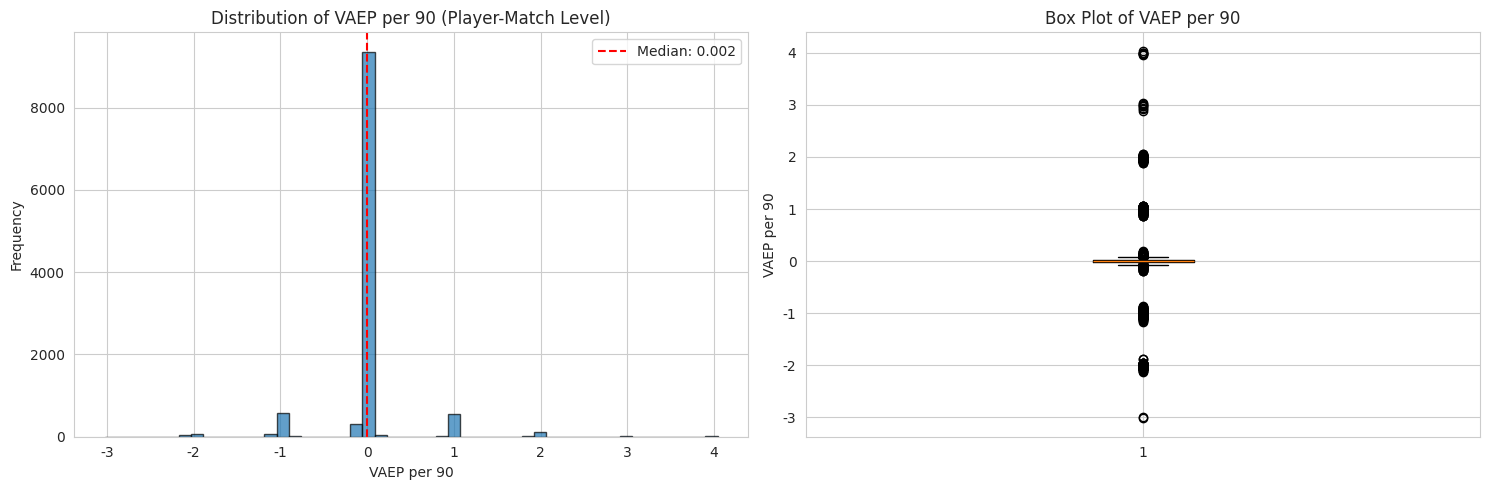

Mean VAEP per 90: 0.0029
Median VAEP per 90: 0.0021
Std VAEP per 90: 0.4562


In [39]:
# VAEP per 90 분포 (Player-match 레벨)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(player_match_df['vaep_per90'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('VAEP per 90')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of VAEP per 90 (Player-Match Level)')
axes[0].axvline(player_match_df['vaep_per90'].median(), color='red', linestyle='--', label=f'Median: {player_match_df["vaep_per90"].median():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(player_match_df['vaep_per90'], vert=True)
axes[1].set_ylabel('VAEP per 90')
axes[1].set_title('Box Plot of VAEP per 90')

plt.tight_layout()
plt.show()

print(f"Mean VAEP per 90: {player_match_df['vaep_per90'].mean():.4f}")
print(f"Median VAEP per 90: {player_match_df['vaep_per90'].median():.4f}")
print(f"Std VAEP per 90: {player_match_df['vaep_per90'].std():.4f}")

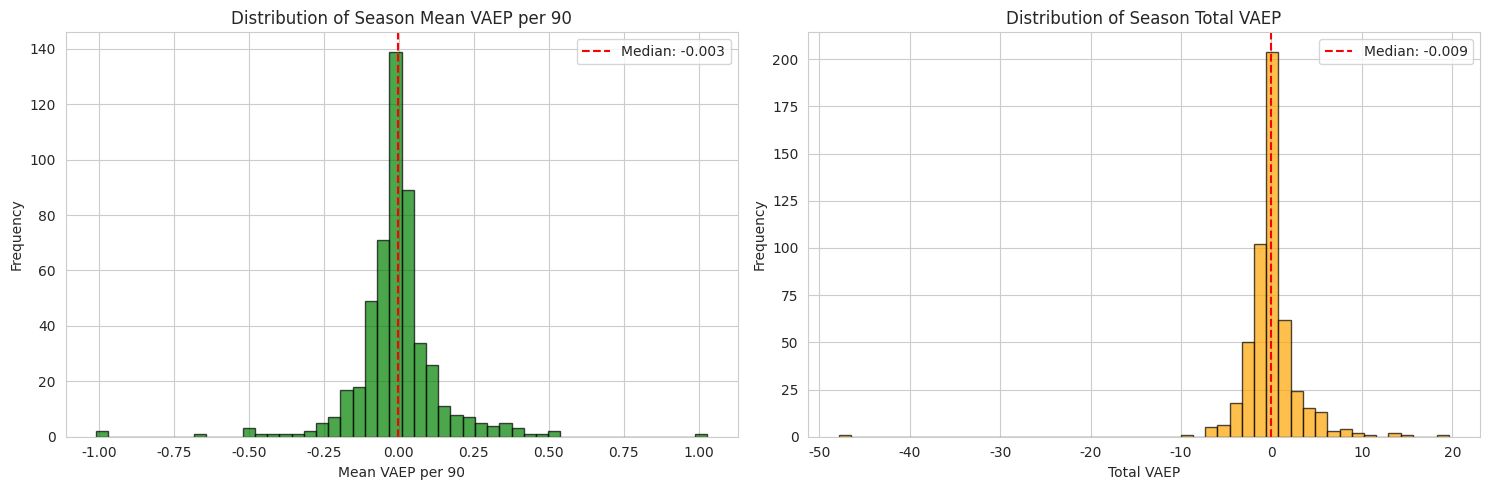

In [40]:
# Season-level VAEP 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mean VAEP per 90 분포 - 실제 컬럼명 사용
vaep_col = 'season_vaep_per90_avg' if 'season_vaep_per90_avg' in player_season_df.columns else 'mean_vaep_per90'
total_col = 'season_vaep_total' if 'season_vaep_total' in player_season_df.columns else 'total_vaep'

axes[0].hist(player_season_df[vaep_col], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Mean VAEP per 90')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Season Mean VAEP per 90')
axes[0].axvline(player_season_df[vaep_col].median(), color='red', linestyle='--', label=f'Median: {player_season_df[vaep_col].median():.3f}')
axes[0].legend()

# Total VAEP 분포
axes[1].hist(player_season_df[total_col], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Total VAEP')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Season Total VAEP')
axes[1].axvline(player_season_df[total_col].median(), color='red', linestyle='--', label=f'Median: {player_season_df[total_col].median():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()


## 4. 상위 선수 분석

In [ ]:
# 최소 경기 수 필터 (신뢰성을 위해)
min_matches = 10
matches_col = 'matches_played' if 'matches_played' in player_season_df.columns else 'num_matches'
qualified_players = player_season_df[player_season_df[matches_col] >= min_matches].copy()

print(f"최소 {min_matches}경기 이상 출전 선수: {len(qualified_players):,}명 (전체 {len(player_season_df):,}명)")


최소 10경기 이상 출전 선수: 387명 (전체 515명)


In [42]:
# Top 20 선수 (mean VAEP per 90 기준)
vaep_col = 'season_vaep_per90_avg' if 'season_vaep_per90_avg' in player_season_df.columns else 'mean_vaep_per90'
total_col = 'season_vaep_total' if 'season_vaep_total' in player_season_df.columns else 'total_vaep'
matches_col = 'matches_played' if 'matches_played' in player_season_df.columns else 'num_matches'
events_col = 'num_events' if 'num_events' in player_season_df.columns else 'total_events'

top_20_vaep_per90 = qualified_players.nlargest(20, vaep_col).copy()

# 선수 이름 추가
top_20_vaep_per90['playerName'] = top_20_vaep_per90['playerId'].apply(get_player_name)

print("=" * 80)
print(f"Top 20 Players by Mean VAEP per 90 (min {min_matches} matches)")
print("=" * 80)
# 선수 이름과 ID를 함께 표시
display_df = top_20_vaep_per90[['playerId', 'playerName', vaep_col, total_col, matches_col, events_col]].copy()
display_df.columns = ['Player ID', 'Player Name', 'VAEP per 90', 'Total VAEP', 'Matches', 'Events']
print(display_df.to_string(index=False))


Top 20 Players by Mean VAEP per 90 (min 10 matches)
 Player ID   Player Name  VAEP per 90  Total VAEP  Matches  Events
      8717       H. Kane     0.530942   19.676787       37    1857
      8325     S. Agüero     0.520208   13.033241       25    1296
    120353 Mohamed Salah     0.446843   14.125019       36    2132
     12829      J. Vardy     0.413985   15.317463       37    1301
      9206       C. Wood     0.397210    7.597146       24    1076
      8249   M. Fellaini     0.385508    4.119933       16     669
     25413  A. Lacazette     0.371590    8.915575       32    1458
    340386 Gabriel Jesus     0.365223    9.640783       29    1158
      7941  J. Hernández     0.355384    7.690173       27     835
    145692     O. Niasse     0.344927    5.657924       22     802
     32636      C. Tosun     0.343826    4.826578       14     672
      8416     G. Murray     0.330042   11.565500       35    1663
      8953     C. Austin     0.323416    5.856491       24     615
     25865

In [ ]:
print("player_season_df columns:", player_season_df.columns.tolist())
print("player_match_df columns:", player_match_df.columns.tolist())

player_season_df columns: ['playerId', 'matches_played', 'season_vaep_total', 'season_vaep_per90_avg', 'minutes_played', 'num_events', 'role', 'season_vaep_per_match']
player_match_df columns: ['playerId', 'matchId', 'teamId', 'vaep', 'num_events', 'minutes_played', 'vaep_per90', 'role']


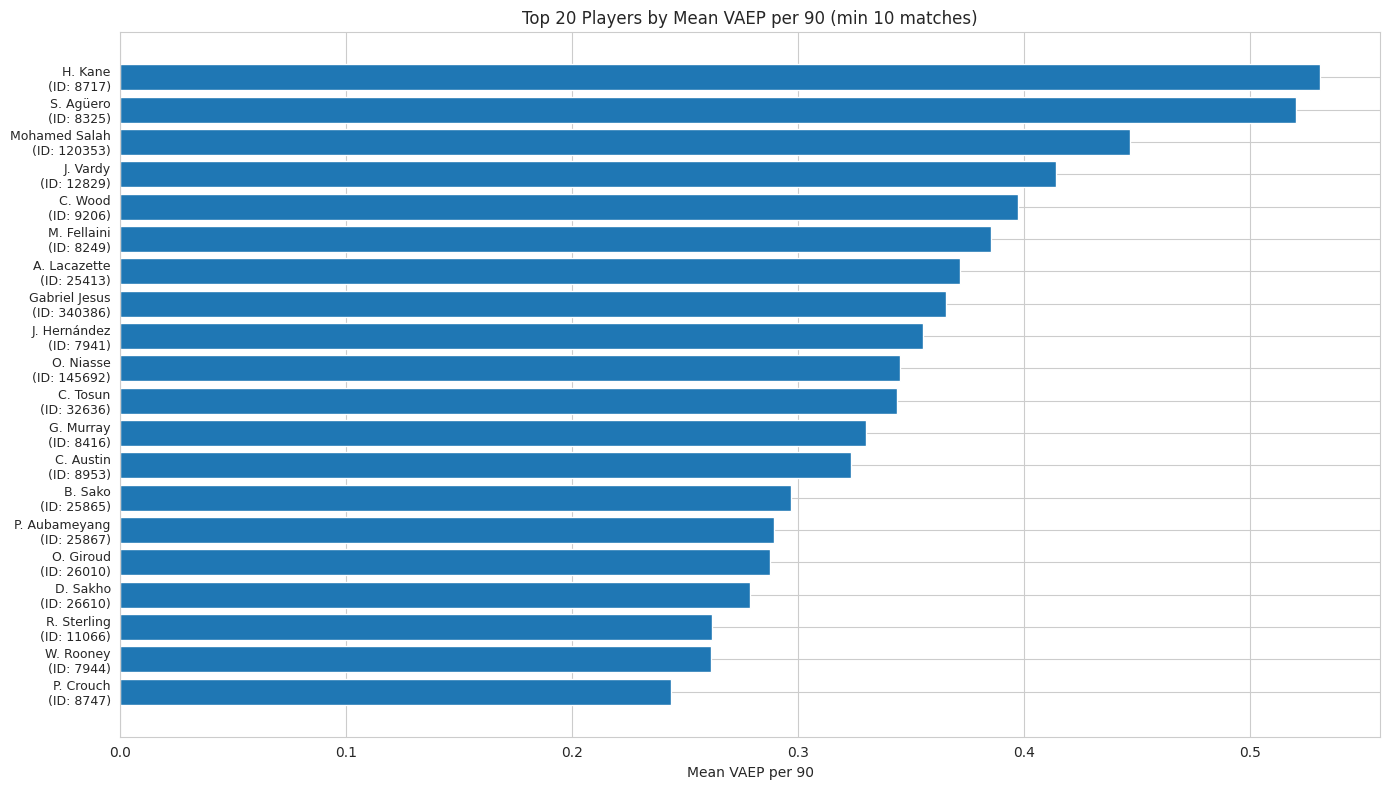

In [ ]:
# Top 20 선수 시각화
plt.figure(figsize=(14, 8))
plt.barh(range(20), top_20_vaep_per90[vaep_col].values[::-1])
# 선수 이름과 ID를 함께 표시
player_labels = [f"{name}\n(ID: {pid})" for name, pid in 
                 zip(top_20_vaep_per90['playerName'].values[::-1], 
                     top_20_vaep_per90['playerId'].values[::-1])]
plt.yticks(range(20), player_labels, fontsize=9)
plt.xlabel('Mean VAEP per 90')
plt.title(f'Top 20 Players by Mean VAEP per 90 (min {min_matches} matches)')
plt.tight_layout()
plt.show()

In [45]:
# Top 20 선수 (total VAEP 기준)
top_20_total_vaep = qualified_players.nlargest(20, total_col).copy()

# 선수 이름 추가
top_20_total_vaep['playerName'] = top_20_total_vaep['playerId'].apply(get_player_name)

print("=" * 80)
print(f"Top 20 Players by Total VAEP (min {min_matches} matches)")
print("=" * 80)
# 선수 이름과 ID를 함께 표시
display_df = top_20_total_vaep[['playerId', 'playerName', total_col, vaep_col, matches_col, events_col]].copy()
display_df.columns = ['Player ID', 'Player Name', 'Total VAEP', 'VAEP per 90', 'Matches', 'Events']
print(display_df.to_string(index=False))

Top 20 Players by Total VAEP (min 10 matches)
 Player ID     Player Name  Total VAEP  VAEP per 90  Matches  Events
      8717         H. Kane   19.676787     0.530942       37    1857
     12829        J. Vardy   15.317463     0.413985       37    1301
    120353   Mohamed Salah   14.125019     0.446843       36    2132
      8325       S. Agüero   13.033241     0.520208       25    1296
      8416       G. Murray   11.565500     0.330042       35    1663
    340386   Gabriel Jesus    9.640783     0.365223       29    1158
     25413    A. Lacazette    8.915575     0.371590       32    1458
     15808 Roberto Firmino    8.764764     0.236590       37    2323
      7944       W. Rooney    8.061972     0.261292       31    1915
      7941    J. Hernández    7.690173     0.355384       27     835
      9206         C. Wood    7.597146     0.397210       24    1076
    127537  L. Milivojević    7.386781     0.204782       36    2639
      9123       A. Barnes    7.314701     0.228694      

## 5. VAEP vs 경기/이벤트 수 상관관계

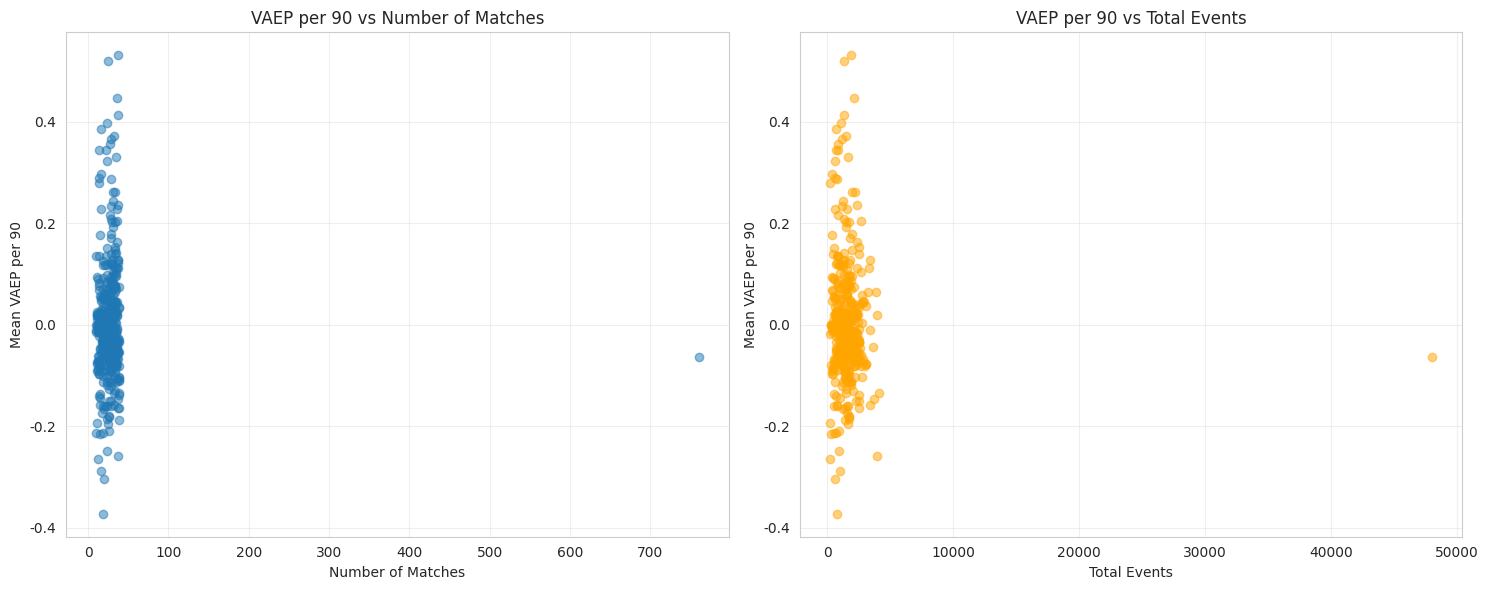

Correlation (Matches vs VAEP per 90): -0.0097
Correlation (Events vs VAEP per 90): -0.0484


In [46]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# VAEP per 90 vs 경기 수
axes[0].scatter(qualified_players[matches_col], qualified_players[vaep_col], alpha=0.5)
axes[0].set_xlabel('Number of Matches')
axes[0].set_ylabel('Mean VAEP per 90')
axes[0].set_title('VAEP per 90 vs Number of Matches')
axes[0].grid(True, alpha=0.3)

# VAEP per 90 vs 이벤트 수
axes[1].scatter(qualified_players[events_col], qualified_players[vaep_col], alpha=0.5, color='orange')
axes[1].set_xlabel('Total Events')
axes[1].set_ylabel('Mean VAEP per 90')
axes[1].set_title('VAEP per 90 vs Total Events')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 상관계수 계산
corr_matches = qualified_players[[matches_col, vaep_col]].corr().iloc[0, 1]
corr_events = qualified_players[[events_col, vaep_col]].corr().iloc[0, 1]

print(f"Correlation (Matches vs VAEP per 90): {corr_matches:.4f}")
print(f"Correlation (Events vs VAEP per 90): {corr_events:.4f}")

## 6. 경기당 VAEP 변동성 분석

In [ ]:
# 경기가 10개 이상인 선수들의 VAEP 변동성 계산
player_variability = player_match_df.groupby('playerId').agg({
    'vaep_per90': ['mean', 'std', 'count']
}).reset_index()

player_variability.columns = ['playerId', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']
player_variability = player_variability[player_variability['num_matches'] >= min_matches].copy()
player_variability['cv'] = player_variability['std_vaep_per90'] / player_variability['mean_vaep_per90'].abs()

print("=" * 80)
print("VAEP Variability Analysis")
print("=" * 80)
print(f"\nMean standard deviation: {player_variability['std_vaep_per90'].mean():.4f}")
print(f"Median standard deviation: {player_variability['std_vaep_per90'].median():.4f}")

VAEP Variability Analysis

Mean standard deviation: 0.3875
Median standard deviation: 0.3640


In [48]:
# Most consistent players (낮은 표준편차)
most_consistent = player_variability.nsmallest(10, 'std_vaep_per90').copy()
most_consistent['playerName'] = most_consistent['playerId'].apply(get_player_name)
print("\nTop 10 Most Consistent Players (lowest std):")
display_df = most_consistent[['playerId', 'playerName', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']].copy()
display_df.columns = ['Player ID', 'Player Name', 'Mean VAEP per 90', 'Std VAEP per 90', 'Matches']
print(display_df.to_string(index=False))

# Most variable players (높은 표준편차)
most_variable = player_variability.nlargest(10, 'std_vaep_per90').copy()
most_variable['playerName'] = most_variable['playerId'].apply(get_player_name)
print("\nTop 10 Most Variable Players (highest std):")
display_df = most_variable[['playerId', 'playerName', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']].copy()
display_df.columns = ['Player ID', 'Player Name', 'Mean VAEP per 90', 'Std VAEP per 90', 'Matches']
print(display_df.to_string(index=False))


Top 10 Most Consistent Players (lowest std):
 Player ID    Player Name  Mean VAEP per 90  Std VAEP per 90  Matches
      8826      K. Darlow          0.000466         0.007697       10
    240559   J. Riedewald          0.000448         0.009837       12
     14688       S. Prödl          0.014990         0.010320       21
    149019     D. Simpson          0.021673         0.010836       28
     86308       C. Yacob          0.016498         0.011075       16
    397168 T. Fosu-Mensah          0.014738         0.012073       21
      9380      J. Stones          0.013706         0.012620       17
      8897        J. Hogg          0.013646         0.012680       30
      9293        M. Pugh         -0.016596         0.013689       20
     77557   W. Routledge          0.000261         0.013766       14

Top 10 Most Variable Players (highest std):
 Player ID   Player Name  Mean VAEP per 90  Std VAEP per 90  Matches
     26010     O. Giroud          0.287427         1.142098       29
 

## 7. 경기별 VAEP 추이 (샘플 선수)

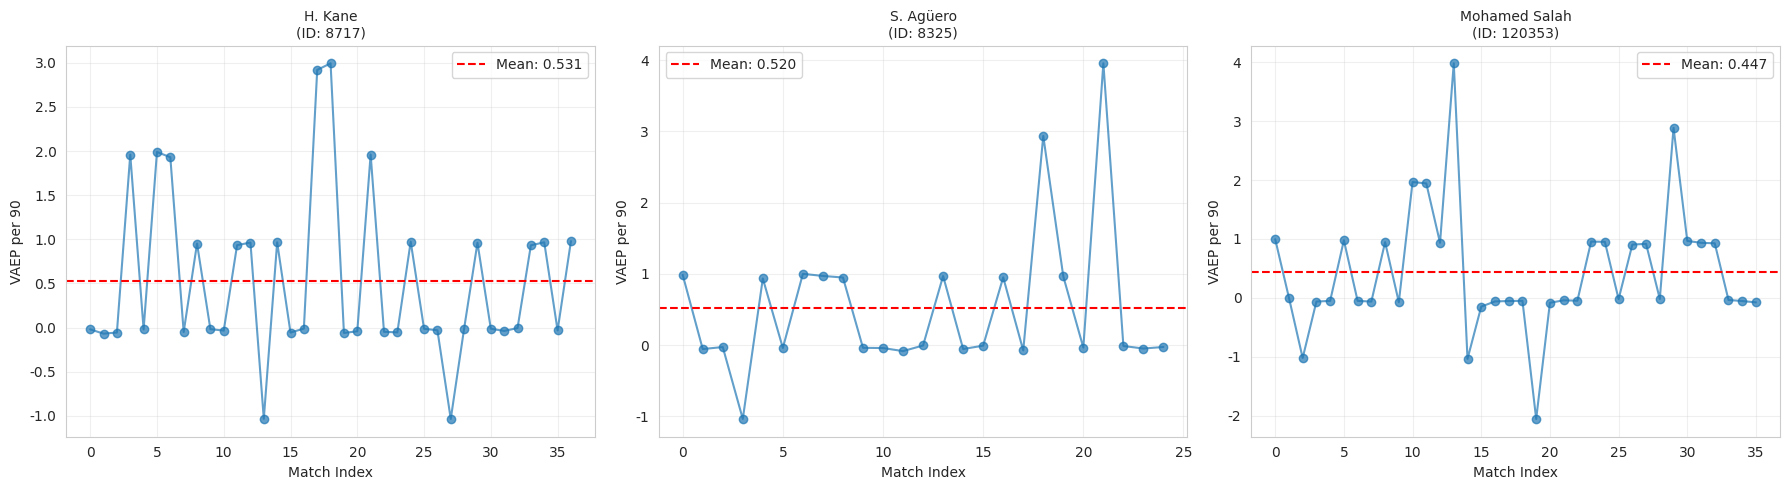

In [49]:
# Top 선수 3명의 경기별 VAEP 추이
top_3_players = top_20_vaep_per90.head(3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, player_row) in enumerate(top_3_players.iterrows()):
    player_id = player_row['playerId']
    player_name = player_row['playerName']
    player_matches = player_match_df[player_match_df['playerId'] == player_id].sort_values('matchId')
    
    axes[idx].plot(range(len(player_matches)), player_matches['vaep_per90'].values, marker='o', linestyle='-', alpha=0.7)
    axes[idx].axhline(player_matches['vaep_per90'].mean(), color='red', linestyle='--', label=f'Mean: {player_matches["vaep_per90"].mean():.3f}')
    axes[idx].set_xlabel('Match Index')
    axes[idx].set_ylabel('VAEP per 90')
    axes[idx].set_title(f'{player_name}\n(ID: {player_id})', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 요약 통계

In [50]:
# 골키퍼만 필터링
gk_season_df = player_season_df[player_season_df['role'] == 'GK'].copy()
gk_match_df = player_match_df[player_match_df['role'] == 'GK'].copy()

print("=" * 80)
print("골키퍼(Goalkeeper) 전용 분석")
print("=" * 80)
print(f"\n총 골키퍼 수: {len(gk_season_df):,}")
print(f"총 골키퍼-경기 조합: {len(gk_match_df):,}")

if len(gk_season_df) > 0:
    print(f"\n골키퍼 VAEP 통계:")
    print(f"  - Mean VAEP per 90: {gk_season_df[vaep_col].mean():.4f} ± {gk_season_df[vaep_col].std():.4f}")
    print(f"  - Median VAEP per 90: {gk_season_df[vaep_col].median():.4f}")
    print(f"  - Min VAEP per 90: {gk_season_df[vaep_col].min():.4f}")
    print(f"  - Max VAEP per 90: {gk_season_df[vaep_col].max():.4f}")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")

골키퍼(Goalkeeper) 전용 분석

총 골키퍼 수: 38
총 골키퍼-경기 조합: 766

골키퍼 VAEP 통계:
  - Mean VAEP per 90: -0.1202 ± 0.1305
  - Median VAEP per 90: -0.0866
  - Min VAEP per 90: -0.5015
  - Max VAEP per 90: 0.0085


/tmp/ipykernel_203453/1050260221.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data_to_plot, labels=['Field Players', 'Goalkeepers'], patch_artist=True)


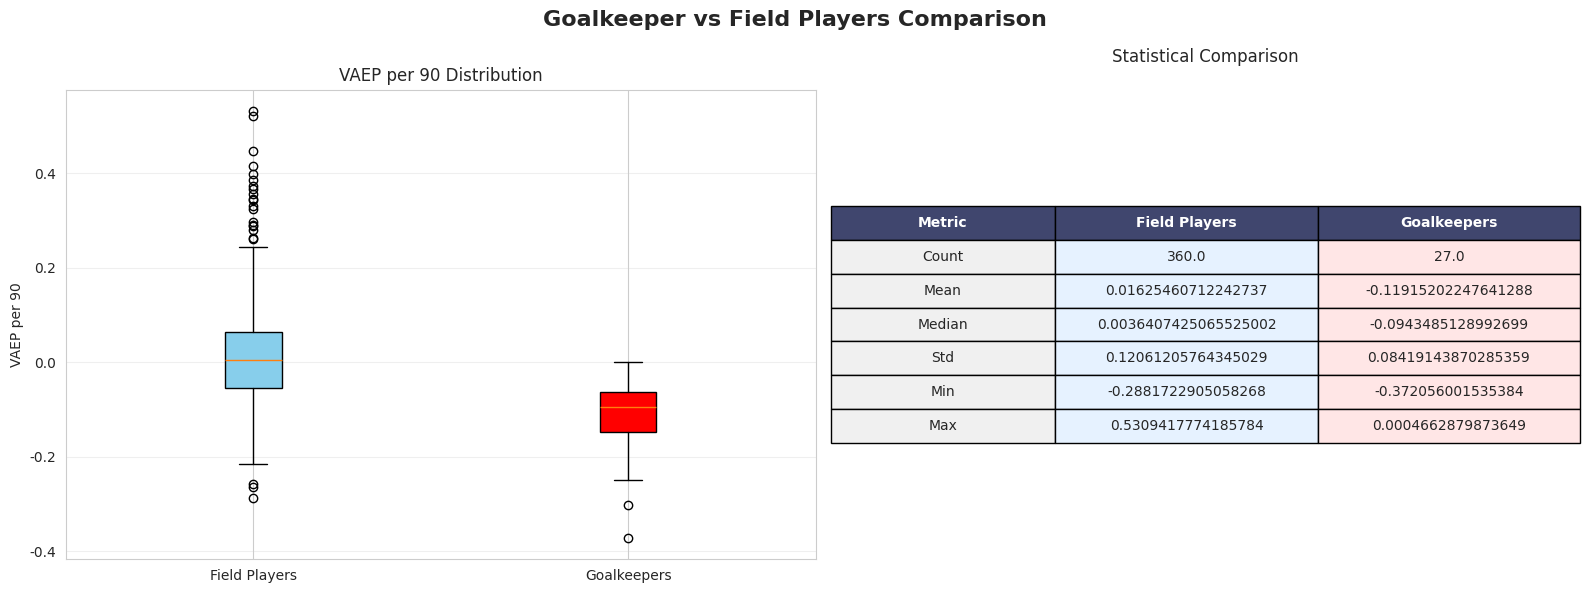


Goalkeeper vs Field Players Statistical Test
Mann-Whitney U test:
  - Statistic: 8360.00
  - P-value: 0.000000
  - Significant difference: Yes (α=0.05)


In [ ]:
# 골키퍼 vs 필드 플레이어 비교
if len(gk_season_df) > 0:
    field_players_df = player_season_df[player_season_df['role'] != 'GK'].copy()
    
    # 최소 경기 수 필터
    gk_qualified = gk_season_df[gk_season_df[matches_col] >= min_matches]
    field_qualified = field_players_df[field_players_df[matches_col] >= min_matches]
    
    if len(gk_qualified) > 0 and len(field_qualified) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Goalkeeper vs Field Players Comparison', fontsize=16, fontweight='bold')
        
        # VAEP per 90 비교
        data_to_plot = [field_qualified[vaep_col].values, gk_qualified[vaep_col].values]
        bp = axes[0].boxplot(data_to_plot, labels=['Field Players', 'Goalkeepers'], patch_artist=True)
        bp['boxes'][0].set_facecolor('skyblue')
        bp['boxes'][1].set_facecolor('red')
        axes[0].set_ylabel('VAEP per 90')
        axes[0].set_title('VAEP per 90 Distribution')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # 통계 비교
        comparison_stats = pd.DataFrame({
            'Metric': ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max'],
            'Field Players': [
                len(field_qualified),
                field_qualified[vaep_col].mean(),
                field_qualified[vaep_col].median(),
                field_qualified[vaep_col].std(),
                field_qualified[vaep_col].min(),
                field_qualified[vaep_col].max()
            ],
            'Goalkeepers': [
                len(gk_qualified),
                gk_qualified[vaep_col].mean(),
                gk_qualified[vaep_col].median(),
                gk_qualified[vaep_col].std(),
                gk_qualified[vaep_col].min(),
                gk_qualified[vaep_col].max()
            ]
        })
        
        axes[1].axis('tight')
        axes[1].axis('off')
        table = axes[1].table(cellText=comparison_stats.values,
                             colLabels=comparison_stats.columns,
                             cellLoc='center',
                             loc='center',
                             colWidths=[0.3, 0.35, 0.35])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # 헤더 스타일
        for i in range(len(comparison_stats.columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # 데이터 행 스타일
        for i in range(1, len(comparison_stats) + 1):
            table[(i, 0)].set_facecolor('#f0f0f0')
            table[(i, 1)].set_facecolor('#e6f2ff')
            table[(i, 2)].set_facecolor('#ffe6e6')
        
        axes[1].set_title('Statistical Comparison', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 80)
        print("Goalkeeper vs Field Players Statistical Test")
        print("=" * 80)
        from scipy import stats
        statistic, pvalue = stats.mannwhitneyu(field_qualified[vaep_col], gk_qualified[vaep_col], alternative='two-sided')
        print(f"Mann-Whitney U test:")
        print(f"  - Statistic: {statistic:.2f}")
        print(f"  - P-value: {pvalue:.6f}")
        print(f"  - Significant difference: {'Yes' if pvalue < 0.05 else 'No'} (α=0.05)")
    else:
        print("\n⚠️ 비교할 충분한 데이터가 없습니다.")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")


최소 10경기 출전 골키퍼: 27명

Top 20 Goalkeepers by Mean VAEP per 90
 Player ID   Player Name  VAEP per 90  Total VAEP  Matches  Events
      8826     K. Darlow     0.000466    0.004663       10     417
     71654       Ederson    -0.025819   -0.949258       37    1242
     15175     L. Karius    -0.049906   -0.948207       19     707
      7910  David de Gea    -0.055062   -2.037279       37    1237
      7882       P. Čech    -0.057971   -1.971003       34    1278
     12242       N. Pope    -0.059875   -2.095632       35    1496
      8094    J. Butland    -0.060588   -2.120586       35    1544
      7974     R. Elliot    -0.067217   -1.075477       16     660
      8425  W. Hennessey    -0.077862   -2.102275       27     985
      7847  Ł. Fabiański    -0.081811   -3.108817       38    1504
      3429   T. Courtois    -0.085342   -2.986954       35    1346
    104851   M. Dúbravka    -0.087819   -1.053834       12     428
      8391    J. Speroni    -0.090322   -0.993544       11     356
 

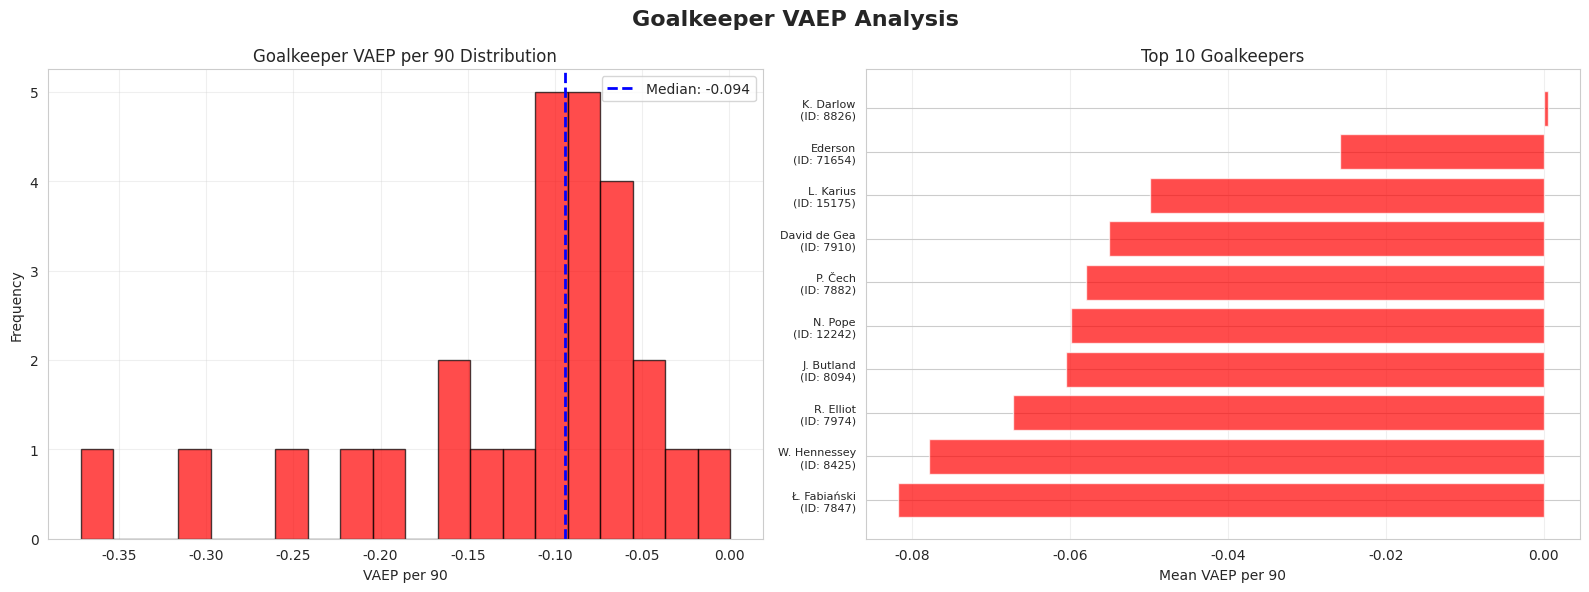

In [52]:
# 골키퍼 Top 20
if len(gk_season_df) > 0:
    gk_qualified = gk_season_df[gk_season_df[matches_col] >= min_matches].copy()
    
    if len(gk_qualified) > 0:
        top_gk = gk_qualified.nlargest(min(20, len(gk_qualified)), vaep_col).copy()
        
        # 선수 이름 추가
        top_gk['playerName'] = top_gk['playerId'].apply(get_player_name)
        
        print(f"\n최소 {min_matches}경기 출전 골키퍼: {len(gk_qualified):,}명")
        print("\n" + "=" * 80)
        print(f"Top {len(top_gk)} Goalkeepers by Mean VAEP per 90")
        print("=" * 80)
        display_df = top_gk[['playerId', 'playerName', vaep_col, total_col, matches_col, events_col]].copy()
        display_df.columns = ['Player ID', 'Player Name', 'VAEP per 90', 'Total VAEP', 'Matches', 'Events']
        print(display_df.to_string(index=False))
        
        # 골키퍼 시각화
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Goalkeeper VAEP Analysis', fontsize=16, fontweight='bold')
        
        # VAEP per 90 분포
        axes[0].hist(gk_qualified[vaep_col], bins=20, edgecolor='black', alpha=0.7, color='red')
        axes[0].axvline(gk_qualified[vaep_col].median(), color='blue', linestyle='--', 
                       label=f'Median: {gk_qualified[vaep_col].median():.3f}', linewidth=2)
        axes[0].set_xlabel('VAEP per 90')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Goalkeeper VAEP per 90 Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Top 골키퍼 바 차트
        top_n = min(10, len(top_gk))
        axes[1].barh(range(top_n), top_gk[vaep_col].values[:top_n][::-1], color='red', alpha=0.7)
        axes[1].set_yticks(range(top_n))
        # 선수 이름과 ID를 함께 표시
        gk_labels = [f"{name}\n(ID: {pid})" for name, pid in 
                     zip(top_gk['playerName'].values[:top_n][::-1], 
                         top_gk['playerId'].values[:top_n][::-1])]
        axes[1].set_yticklabels(gk_labels, fontsize=8)
        axes[1].set_xlabel('Mean VAEP per 90')
        axes[1].set_title(f'Top {top_n} Goalkeepers')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n⚠️ 최소 {min_matches}경기 이상 출전한 골키퍼가 없습니다.")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")

## 9. 골키퍼 전용 분석

In [ ]:
print("=" * 80)
print("VAEP Pipeline Results Summary")
print("=" * 80)

print(f"\n데이터셋 정보:")
print(f"  - 총 선수 수: {player_season_df['playerId'].nunique():,}")
print(f"  - 총 경기 수: {player_match_df['matchId'].nunique():,}")
print(f"  - 총 선수-경기 조합: {len(player_match_df):,}")
print(f"  - {min_matches}경기 이상 출전 선수: {len(qualified_players):,}")

print(f"\nVAEP 통계 (전체):")
print(f"  - Mean VAEP per 90: {player_season_df[vaep_col].mean():.4f} ± {player_season_df[vaep_col].std():.4f}")
print(f"  - Median VAEP per 90: {player_season_df[vaep_col].median():.4f}")
print(f"  - Min VAEP per 90: {player_season_df[vaep_col].min():.4f}")
print(f"  - Max VAEP per 90: {player_season_df[vaep_col].max():.4f}")

print(f"\nVAEP 통계 ({min_matches}경기 이상):")
print(f"  - Mean VAEP per 90: {qualified_players[vaep_col].mean():.4f} ± {qualified_players[vaep_col].std():.4f}")
print(f"  - Median VAEP per 90: {qualified_players[vaep_col].median():.4f}")
print(f"  - Min VAEP per 90: {qualified_players[vaep_col].min():.4f}")
print(f"  - Max VAEP per 90: {qualified_players[vaep_col].max():.4f}")

print("\n분석 완료!")

VAEP Pipeline Results Summary

데이터셋 정보:
  - 총 선수 수: 515
  - 총 경기 수: 380
  - 총 선수-경기 조합: 11,178
  - 10경기 이상 출전 선수: 387

VAEP 통계 (전체):
  - Mean VAEP per 90: -0.0048 ± 0.1491
  - Median VAEP per 90: -0.0033
  - Min VAEP per 90: -1.0088
  - Max VAEP per 90: 1.0278

VAEP 통계 (10경기 이상):
  - Mean VAEP per 90: 0.0068 ± 0.1233
  - Median VAEP per 90: -0.0045
  - Min VAEP per 90: -0.3721
  - Max VAEP per 90: 0.5309

분석 완료!


Overall Player Rankings (All Positions)

최소 10경기 이상 출전 선수: 387명

Top 50 Players (All Positions):
----------------------------------------------------------------------------------------------------
 Player ID     Player Name Role  VAEP per 90  Total VAEP  Matches  Events
      8717         H. Kane   FW     0.530942   19.676787       37    1857
      8325       S. Agüero   FW     0.520208   13.033241       25    1296
    120353   Mohamed Salah   FW     0.446843   14.125019       36    2132
     12829        J. Vardy   FW     0.413985   15.317463       37    1301
      9206         C. Wood   FW     0.397210    7.597146       24    1076
      8249     M. Fellaini   MD     0.385508    4.119933       16     669
     25413    A. Lacazette   FW     0.371590    8.915575       32    1458
    340386   Gabriel Jesus   FW     0.365223    9.640783       29    1158
      7941    J. Hernández   FW     0.355384    7.690173       27     835
    145692       O. Niasse   FW     0.344927    5.657924      

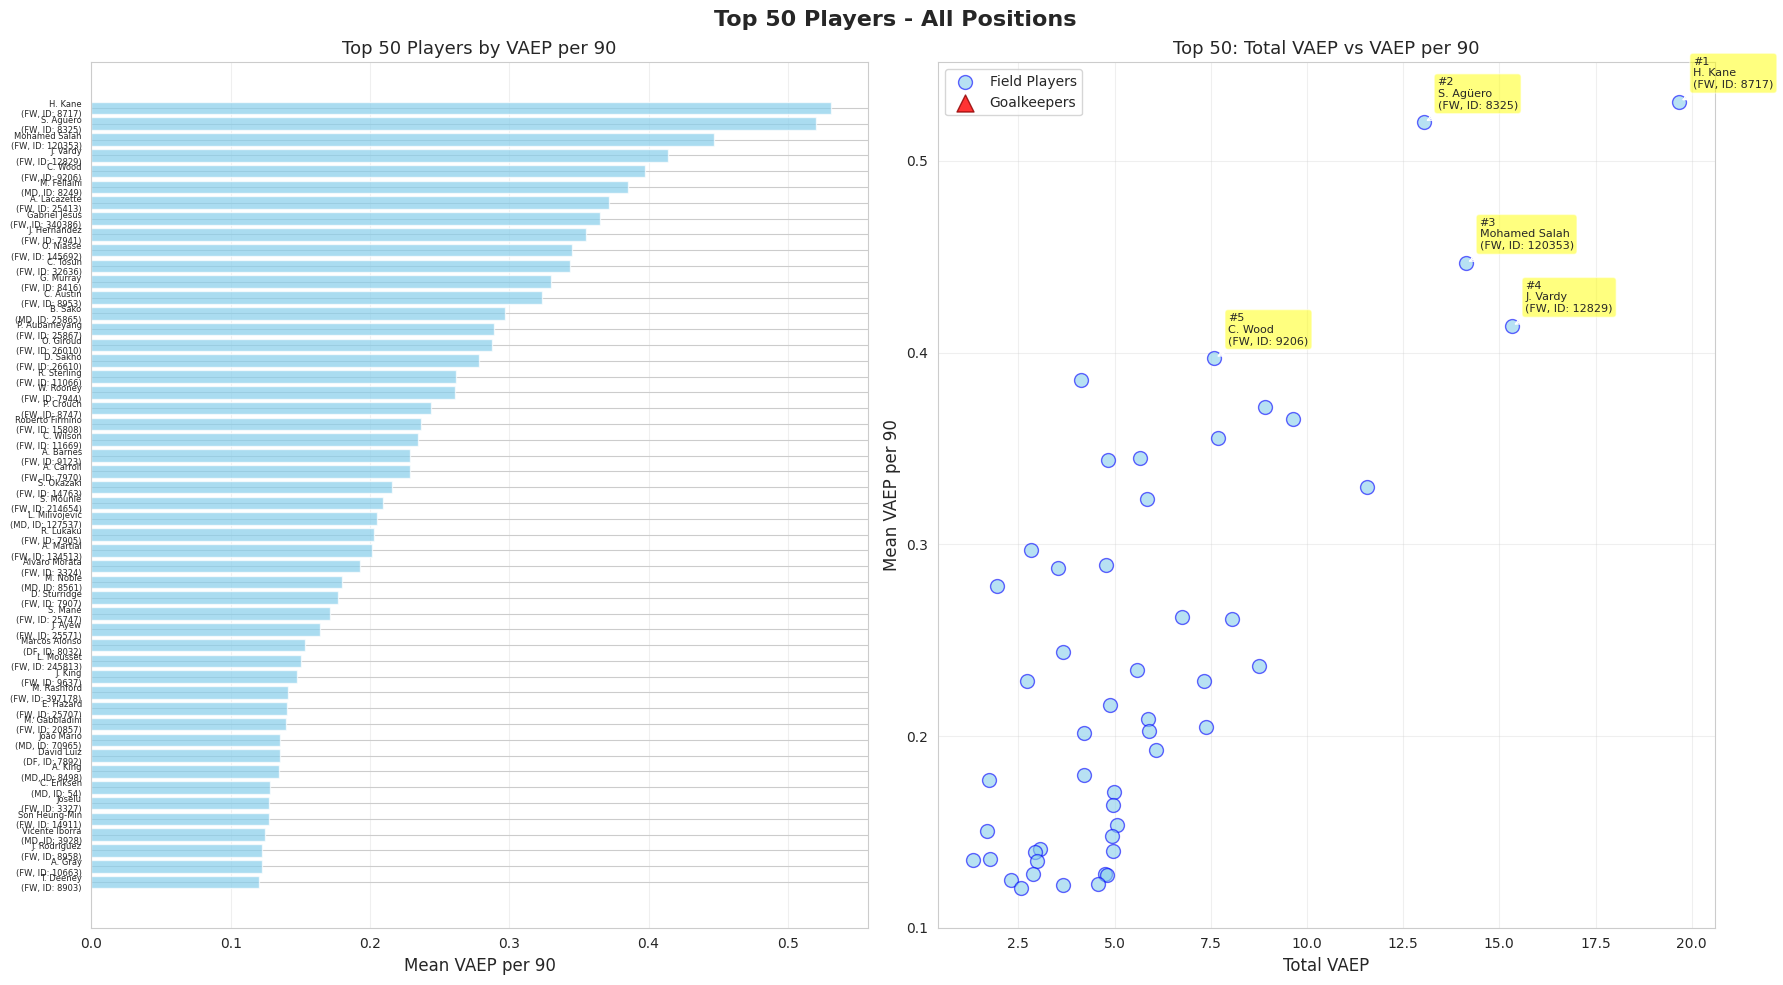

In [54]:
# 전체 선수 랭킹 (Top 50)
print("=" * 100)
print("Overall Player Rankings (All Positions)")
print("=" * 100)

# 최소 경기 수 필터
all_qualified = player_season_df[player_season_df[matches_col] >= min_matches].copy()
top_50_overall = all_qualified.nlargest(50, vaep_col).copy()

# 선수 이름 추가
top_50_overall['playerName'] = top_50_overall['playerId'].apply(get_player_name)

print(f"\n최소 {min_matches}경기 이상 출전 선수: {len(all_qualified):,}명")
print(f"\nTop 50 Players (All Positions):")
print("-" * 100)
display_df = top_50_overall[['playerId', 'playerName', 'role', vaep_col, total_col, matches_col, events_col]].copy()
display_df.columns = ['Player ID', 'Player Name', 'Role', 'VAEP per 90', 'Total VAEP', 'Matches', 'Events']
print(display_df.to_string(index=False))

# Top 50 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 50 Players - All Positions', fontsize=16, fontweight='bold')

# 1. 바 차트
colors_top50 = ['red' if role == 'GK' else 'skyblue' for role in top_50_overall['role']]
axes[0].barh(range(50), top_50_overall[vaep_col].values[::-1], color=colors_top50[::-1], alpha=0.7)
axes[0].set_yticks(range(50))
# 선수 이름과 역할을 함께 표시
player_labels = [f"{name}\n({role}, ID: {pid})" for name, role, pid in 
                 zip(top_50_overall['playerName'].values[::-1],
                     top_50_overall['role'].values[::-1], 
                     top_50_overall['playerId'].values[::-1])]
axes[0].set_yticklabels(player_labels, fontsize=6)
axes[0].set_xlabel('Mean VAEP per 90', fontsize=12)
axes[0].set_title('Top 50 Players by VAEP per 90', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Total VAEP vs VAEP per 90
axes[1].scatter(top_50_overall.loc[top_50_overall['role'] != 'GK', total_col],
               top_50_overall.loc[top_50_overall['role'] != 'GK', vaep_col],
               s=100, alpha=0.6, c='skyblue', label='Field Players', edgecolors='blue')
axes[1].scatter(top_50_overall.loc[top_50_overall['role'] == 'GK', total_col],
               top_50_overall.loc[top_50_overall['role'] == 'GK', vaep_col],
               s=150, alpha=0.8, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')

# Top 5에 레이블 추가 (이름 포함)
for idx, (_, row) in enumerate(top_50_overall.head(5).iterrows()):
    player_name = row['playerName']
    axes[1].annotate(f"#{idx+1}\n{player_name}\n({row['role']}, ID: {row['playerId']})", 
                    xy=(row[total_col], row[vaep_col]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

axes[1].set_xlabel('Total VAEP', fontsize=12)
axes[1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[1].set_title('Top 50: Total VAEP vs VAEP per 90', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_203453/1861594590.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 0].boxplot(role_data, labels=roles, patch_artist=True)


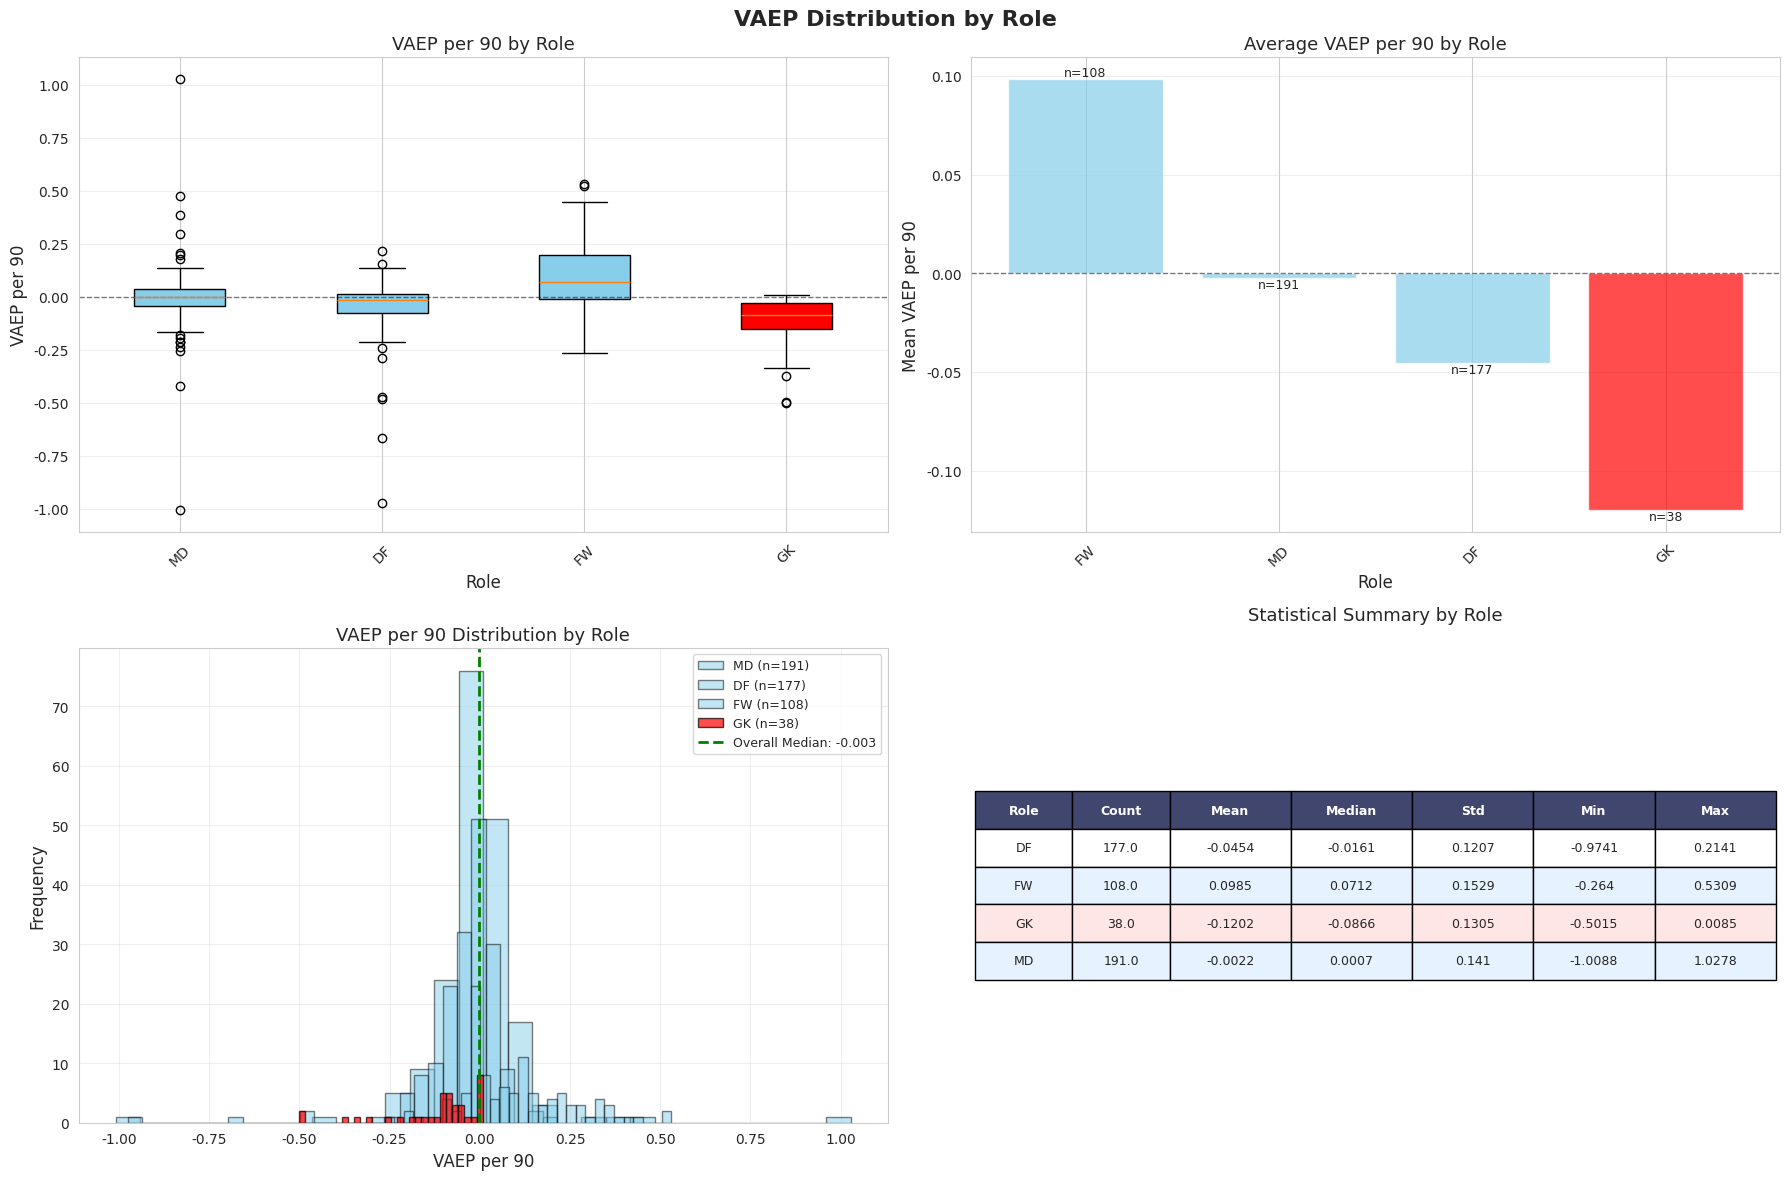


역할별 통계:
      count    mean  median     std     min     max
role                                               
DF      177 -0.0454 -0.0161  0.1207 -0.9741  0.2141
FW      108  0.0985  0.0712  0.1529 -0.2640  0.5309
GK       38 -0.1202 -0.0866  0.1305 -0.5015  0.0085
MD      191 -0.0022  0.0007  0.1410 -1.0088  1.0278


In [55]:
# 포지션별 VAEP 분포 (역할 코드별)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('VAEP Distribution by Role', fontsize=16, fontweight='bold')

# 역할별 그룹화
role_groups = player_season_df.groupby('role')

# 1. 역할별 VAEP per 90 박스플롯
roles = player_season_df['role'].value_counts().index.tolist()
role_data = [player_season_df[player_season_df['role'] == role][vaep_col].values for role in roles]

bp = axes[0, 0].boxplot(role_data, labels=roles, patch_artist=True)
colors = ['red' if role == 'GK' else 'skyblue' for role in roles]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_xlabel('Role', fontsize=12)
axes[0, 0].set_ylabel('VAEP per 90', fontsize=12)
axes[0, 0].set_title('VAEP per 90 by Role', fontsize=13)
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 역할별 평균 VAEP 바 차트
role_means = player_season_df.groupby('role')[vaep_col].agg(['mean', 'count']).sort_values('mean', ascending=False)
colors_bar = ['red' if idx == 'GK' else 'skyblue' for idx in role_means.index]
axes[0, 1].bar(range(len(role_means)), role_means['mean'].values, color=colors_bar, alpha=0.7)
axes[0, 1].set_xticks(range(len(role_means)))
axes[0, 1].set_xticklabels(role_means.index, rotation=45)
axes[0, 1].set_xlabel('Role', fontsize=12)
axes[0, 1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[0, 1].set_title('Average VAEP per 90 by Role', fontsize=13)
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 각 바 위에 선수 수 표시
for i, (idx, row) in enumerate(role_means.iterrows()):
    axes[0, 1].text(i, row['mean'], f"n={int(row['count'])}", 
                   ha='center', va='bottom' if row['mean'] >= 0 else 'top', fontsize=9)

# 3. 전체 선수 VAEP 히스토그램 (역할별 색상)
for role in roles:
    role_data = player_season_df[player_season_df['role'] == role][vaep_col]
    color = 'red' if role == 'GK' else 'skyblue'
    alpha = 0.7 if role == 'GK' else 0.5
    axes[1, 0].hist(role_data, bins=30, alpha=alpha, label=f'{role} (n={len(role_data)})', 
                   color=color, edgecolor='black')

axes[1, 0].axvline(player_season_df[vaep_col].median(), color='green', linestyle='--', 
                  label=f'Overall Median: {player_season_df[vaep_col].median():.3f}', linewidth=2)
axes[1, 0].set_xlabel('VAEP per 90', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('VAEP per 90 Distribution by Role', fontsize=13)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. 역할별 통계 테이블
role_stats = player_season_df.groupby('role')[vaep_col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
role_stats = role_stats.round(4)

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for idx, row in role_stats.iterrows():
    table_data.append([idx] + row.tolist())

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Role', 'Count', 'Mean', 'Median', 'Std', 'Min', 'Max'],
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.12, 0.12, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# 헤더 스타일
for i in range(7):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 데이터 행 스타일
for i in range(1, len(table_data) + 1):
    for j in range(7):
        if table_data[i-1][0] == 'GK':
            table[(i, j)].set_facecolor('#ffe6e6')
        else:
            table[(i, j)].set_facecolor('#e6f2ff' if i % 2 == 0 else 'white')

axes[1, 1].set_title('Statistical Summary by Role', fontsize=13, pad=20)

plt.tight_layout()
plt.show()

print("\n역할별 통계:")
print(role_stats.to_string())

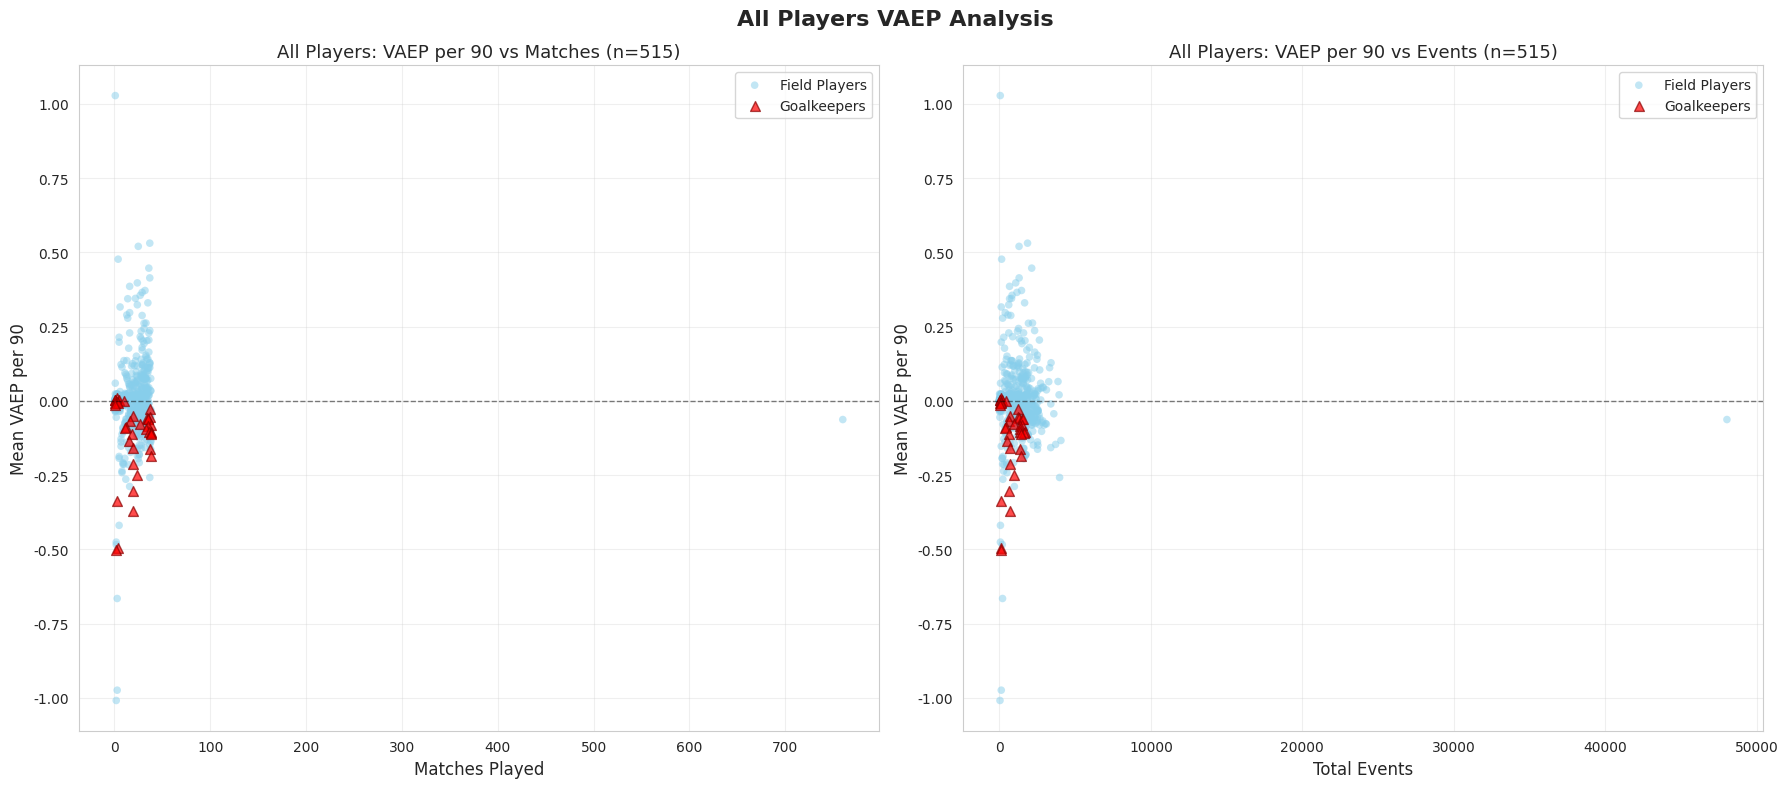


선수 분포:
  - 필드 플레이어: 477명
  - 골키퍼: 38명
  - 총 선수: 515명


In [56]:
# 전체 선수 VAEP per 90 vs 경기 수 산점도
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('All Players VAEP Analysis', fontsize=16, fontweight='bold')

# 골키퍼와 필드 플레이어 분리
gk_mask = player_season_df['role'] == 'GK'
field_mask = player_season_df['role'] != 'GK'

# 1. VAEP per 90 vs Matches Played
axes[0].scatter(player_season_df.loc[field_mask, matches_col], 
               player_season_df.loc[field_mask, vaep_col],
               alpha=0.5, s=30, c='skyblue', label='Field Players', edgecolors='none')
axes[0].scatter(player_season_df.loc[gk_mask, matches_col], 
               player_season_df.loc[gk_mask, vaep_col],
               alpha=0.7, s=50, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Matches Played', fontsize=12)
axes[0].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[0].set_title(f'All Players: VAEP per 90 vs Matches (n={len(player_season_df)})', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. VAEP per 90 vs Total Events
axes[1].scatter(player_season_df.loc[field_mask, events_col], 
               player_season_df.loc[field_mask, vaep_col],
               alpha=0.5, s=30, c='skyblue', label='Field Players', edgecolors='none')
axes[1].scatter(player_season_df.loc[gk_mask, events_col], 
               player_season_df.loc[gk_mask, vaep_col],
               alpha=0.7, s=50, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Total Events', fontsize=12)
axes[1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[1].set_title(f'All Players: VAEP per 90 vs Events (n={len(player_season_df)})', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n선수 분포:")
print(f"  - 필드 플레이어: {field_mask.sum():,}명")
print(f"  - 골키퍼: {gk_mask.sum():,}명")
print(f"  - 총 선수: {len(player_season_df):,}명")

## 10. 전체 선수 시각화 (All Players Plot)